In [82]:
import pandas as pd

# Load the conjoint data
conjoint_data = pd.read_csv('conjoint_data.csv')

# Create dummy variables
conjoint_data = pd.get_dummies(conjoint_data, columns=['brand', 'ad'], drop_first=True)

# Rename for clarity (optional)
conjoint_data = conjoint_data.rename(columns={
    'brand_N': 'brand_Netflix',
    'brand_P': 'brand_Prime',
    'ad_Yes': 'ad_Yes'
})

# View the structure
print(conjoint_data.head(6))



   resp  task  choice  price  brand_Netflix  brand_Prime  ad_Yes
0     1     1       1     28           True        False    True
1     1     1       0     16          False        False    True
2     1     1       0     16          False         True    True
3     1     2       0     32           True        False    True
4     1     2       1     16          False         True    True
5     1     2       0     24           True        False    True


In [83]:
from scipy.optimize import minimize
import numpy as np
import pandas as pd

# Design matrix and outcome
X = conjoint_data[["brand_Netflix", "brand_Prime", "ad_Yes", "price"]].astype(float).values
y = conjoint_data["choice"].astype(int).values

# Define groups
group_ids = conjoint_data["resp"].astype(str) + "_" + conjoint_data["task"].astype(str)
groups = group_ids.values
unique_tasks = np.unique(groups)

# Log-likelihood function with type-safe operations
def log_likelihood(beta):
    beta = np.asarray(beta, dtype=np.float64)
    log_lik = 0.0
    for task in unique_tasks:
        idx = (groups == task)
        X_task = X[idx]
        y_task = y[idx]
        utilities = X_task @ beta
        exp_utilities = np.exp(utilities)
        probs = exp_utilities / np.sum(exp_utilities)
        log_lik += np.sum(y_task * np.log(probs))
    return -log_lik

# Initial parameter guess
beta_init = np.zeros(X.shape[1])

# Run optimization
result = minimize(log_likelihood, beta_init, method='BFGS')

# Extract parameter estimates and compute standard errors
beta_hat = result.x
hessian_inv = result.hess_inv
standard_errors = np.sqrt(np.diag(hessian_inv))
conf_ints = np.array([beta_hat - 1.96 * standard_errors, beta_hat + 1.96 * standard_errors]).T

# Package results
results_df = pd.DataFrame({
    "Parameter": ["beta_Netflix", "beta_Prime", "beta_Ads", "beta_Price"],
    "Estimate": beta_hat,
    "Std. Error": standard_errors,
    "CI Lower (95%)": conf_ints[:, 0],
    "CI Upper (95%)": conf_ints[:, 1]
})

results_df

,Parameter,Estimate,Std. Error,CI Lower (95%),CI Upper (95%)
0,beta_Netflix,0.941195,0.019594,0.902791,0.979599
1,beta_Prime,0.501616,0.038609,0.425942,0.577290
2,beta_Ads,-0.731995,0.022118,-0.775346,-0.688643
3,beta_Price,-0.099480,0.006165,-0.111564,-0.087397


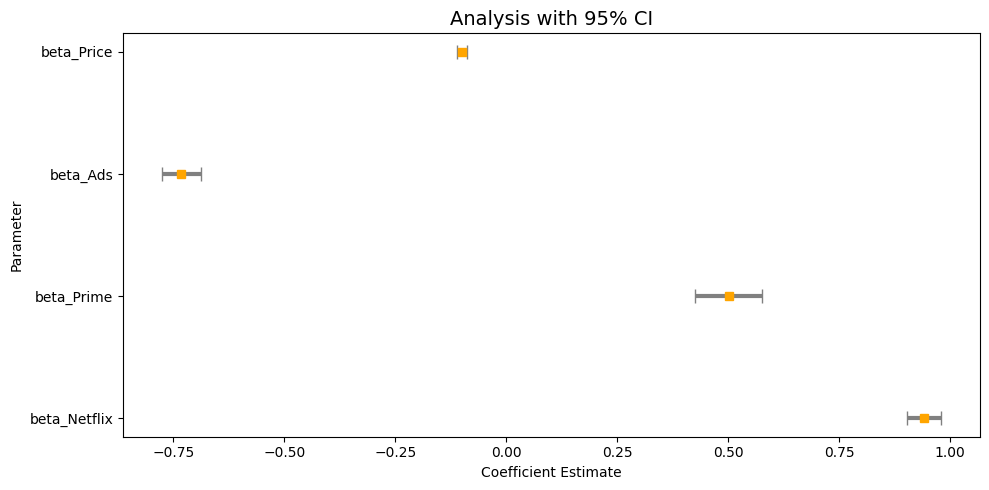

In [95]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 5))

ax.errorbar(
    results_df["Estimate"],
    results_df["Parameter"],
    xerr=1.96 * results_df["Std. Error"],
    fmt='s',
    color='orange',
    ecolor='grey',
    elinewidth=3,
    capsize=5
)


ax.set_title("Analysis with 95% CI", fontsize=14)
ax.set_xlabel("Coefficient Estimate")
ax.set_ylabel("Parameter")

plt.tight_layout()
plt.show()




In [104]:


# Group structure: each choice set (task) includes 3 rows
n_rows = X.shape[0]
n_alts = 3
n_tasks = n_rows // n_alts

# Reshape into 3D arrays for vectorized operations: (tasks, alts, features)
X_3d = X.reshape((n_tasks, n_alts, -1))
y_2d = y.reshape((n_tasks, n_alts))

# Log-likelihood function in vectorized form
def log_likelihood(beta):
    utilities = np.einsum('taj,j->ta', X_3d, beta)  # dot product for each alternative
    max_u = np.max(utilities, axis=1, keepdims=True)
    exp_u = np.exp(utilities - max_u)  # for numerical stability
    probs = exp_u / np.sum(exp_u, axis=1, keepdims=True)
    log_probs = np.log(probs + 1e-12)
    return -np.sum(log_probs * y_2d)

# Log-prior function
def log_prior(beta):
    prior_binary = -0.5 * ((beta[:3] / 5) ** 2) - np.log(5 * np.sqrt(2 * np.pi))
    prior_price = -0.5 * ((beta[3] / 1) ** 2) - np.log(1 * np.sqrt(2 * np.pi))
    return np.sum(prior_binary) + prior_price

# Log-posterior
def log_posterior(beta):
    return -log_likelihood(beta) + log_prior(beta)

# Metropolis-Hastings MCMC
n_steps = 11000
burn_in = 1000
n_keep = n_steps - burn_in
dim = X.shape[1]
samples = np.zeros((n_keep, dim))

# Initial beta and posterior
np.random.seed(42)
current_beta = np.zeros(dim)
current_log_post = log_posterior(current_beta)

# Proposal standard deviations (per hint)
proposal_sd = np.array([0.05, 0.05, 0.05, 0.005])
accepted = 0

# Run Metropolis-Hastings
for step in range(n_steps):
    proposal = current_beta + np.random.normal(0, proposal_sd)
    proposal_log_post = log_posterior(proposal)
    log_accept_ratio = proposal_log_post - current_log_post

    if np.log(np.random.rand()) < log_accept_ratio:
        current_beta = proposal
        current_log_post = proposal_log_post
        accepted += 1

    if step >= burn_in:
        samples[step - burn_in] = current_beta

# Summarize posterior
posterior_means = np.mean(samples, axis=0)
posterior_ci_lower = np.percentile(samples, 2.5, axis=0)
posterior_ci_upper = np.percentile(samples, 97.5, axis=0)

posterior_df = pd.DataFrame({
    "Parameter": ["beta_Netflix", "beta_Prime", "beta_Ads", "beta_Price"],
    "Posterior Mean": posterior_means,
    "CI Lower (2.5%)": posterior_ci_lower,
    "CI Upper (97.5%)": posterior_ci_upper
})
posterior_df


,Parameter,Posterior Mean,CI Lower (2.5%),CI Upper (97.5%)
0,beta_Netflix,0.945757,0.732071,1.170714
1,beta_Prime,0.506718,0.288233,0.735044
2,beta_Ads,-0.732612,-0.890905,-0.566756
3,beta_Price,-0.099754,-0.111863,-0.087338
